# Replication of paper "Approximate Bayesian computational methods" (2011)

In [1]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra
using LaTeXStrings
using SymPy
using VegaLite
using DataFrames
pyplot()

Plots.PyPlotBackend()

### **Alorithm 1** - Likelihood-free rejection sampler 1
Let's use sampling from Uniform with binomial likelihood function to illustrate this algorithm.

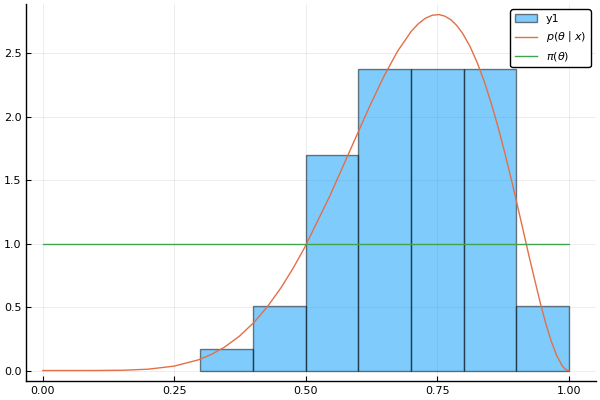

In [2]:
n, x = 8, 6
N = 1000

# Sample θ' from prior π(θ)
# Generate z from p(.|θ')
theta_s = rand(Beta(1,1),N)
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];
v = collect(range(0, stop=1, length=N));

histogram(theta_a,normalize=true,alpha=0.5)
plot!(Beta(x+1,n-x+1),label=L"p(\theta \mid x)")
plot!(Beta(1,1), label =L"\pi(\theta)")

### **Alorithm 2** - Likelihood-free rejection sampler 2

Let's write the functions for calculating the distances between the variables.

##### a) **Moving Average Model**

In [3]:
MA(current, u,t) = u[current+2] + u[current + 1] * t[2] + u[current] * t[1]

function genMA(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end

genMA (generic function with 1 method)

##### b) **Synthetic Dataset**
###### Moving Average model (MA)
$y_k = u_k + \sum_{i=1}^q \theta_i u_{k-i}$

$y \sim MA(q)$

$(\theta_1,\theta_2) =(0.6,0.2)$,sample size of 100.

In [4]:
using Random
Random.seed!(1234)
theta = [0.6;0.2]
n     = 100
u     = randn(n+2)
y     = MA.((1:n),Ref(u),Ref(theta));
# y     = genMA(u',theta',n,1)

##### c) **Distance Functions and Suffient Statistics**

In [5]:
raw_distance(y,z)         = sqrt(sum((y-z).^2))
raw_distance_ordered(y,z) = sqrt(sum((sort(y)-sort(z)).^2))
autocov_distance(q,y,z)   = sqrt((autocov(y,[q],demean=false)[1] - autocov(z,[q],demean=false)[1])^2)[1]

autocov_distance (generic function with 1 method)

##### d) **Triangular Sampling**
Using rejection sampling to sample uniformly in a triangle

In [6]:
function rand_TriUniform(N=1)
    trisample = zeros(N,2)
    count = 0
    while count < N
        theta = [4*rand()-2;2*rand()-1]
        if (theta[1]>-2 && theta[1]<2) && (sum(theta)>-1) && (theta[1]-theta[2] < 1)
            count+=1
            trisample[count,:] = theta
        end
    end
    return trisample
end

rand_TriUniform (generic function with 2 methods)

##### e) **Running Algorithm 2**

In [7]:
N = 10^6        # number of trials
n = length(y) # sample size
theta_s = rand_TriUniform(N)
u       = randn(N,n+2)
z       = genMA(u,theta_s,n,N);

In [74]:
autocov_vectorize(z)    = autocov_distance(2,y,z)
dist_vectorize(z)       = raw_distance(y,z)
distorderd_vectorize(z) = raw_distance_ordered(y,z)
rho_autocov = mapslices(autocov_vectorize, z, dims =2)[:];
rho_disord  = mapslices(distorderd_vectorize, z, dims =2)[:];
rho_dist    = mapslices(dist_vectorize, z, dims =2)[:];

In [124]:
epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
epsilon10e4_disord  = quantile(rho_disord,0.1/100)
epsilon10e4_dist    = quantile(rho_dist,0.1/100)

zacauto = z[rho_autocov .< epsilon10e4_autocov,:];

In [125]:
# autocov_distance(2,zacauto[5,:],y)
# sort(zacauto[1,:]) - sort(y)

In [127]:
theta_ac_auto = theta_s[rho_autocov .< epsilon10e4_autocov,:];
theta_ac_dord = theta_s[rho_disord  .< epsilon10e4_disord,:];
theta_ac_dist = theta_s[rho_dist    .< epsilon10e4_dist,:];

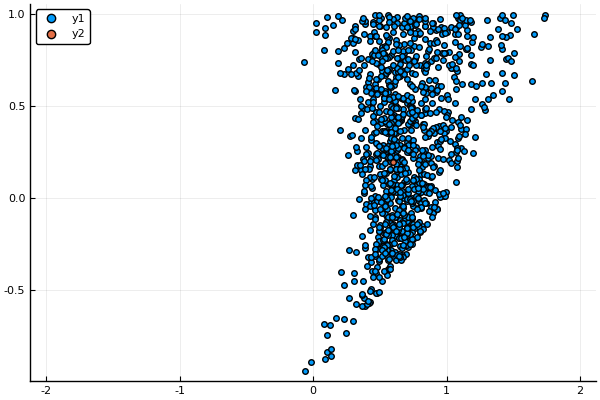

In [129]:
scatter(theta_ac_auto[:,1],theta_ac_auto[:,2],xlims=[-2,2])
scatter!([theta[1]],[theta[2]])
# scatter!(theta_ac_dist[:,1],theta_ac_dist[:,2],xlims=[-2,2])
# scatter!(theta_ac_dord[:,1],theta_ac_dord[:,2],xlims=[-2,2])